# Diabetes Prediction - Complete Pipeline
**Author:** Nilesh Kadale  
**Course:** DTSC691: Applied Data Science  
**Date:** 2024

## Project Overview
This notebook implements a complete machine learning pipeline for diabetes prediction:
1. Data Loading and Exploration
2. Exploratory Data Analysis (EDA)
3. Data Preprocessing
4. Model Training (Logistic Regression, Random Forest, XGBoost, Neural Network)
5. Model Evaluation and Comparison
6. Model Saving for Flask Application

## Dataset
- **Source:** PIMA Indians Diabetes Database (Kaggle)
- **Size:** 768 records, 9 columns (8 features + 1 target)
- **Features:** Pregnancies, Glucose, Blood Pressure, Skin Thickness, Insulin, BMI, Diabetes Pedigree Function, Age
- **Target:** Outcome (1 = Diabetic, 0 = Non-Diabetic)


In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, roc_curve, confusion_matrix, 
                            classification_report)

# Advanced ML - Make XGBoost optional
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("✓ XGBoost imported successfully")
except Exception as e:
    XGBOOST_AVAILABLE = False
    print(f"⚠ XGBoost not available: {e}")
    print("  Continuing without XGBoost. Install libomp with: brew install libomp")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Model persistence
import joblib
import os

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("\nLibraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


✓ XGBoost imported successfully


2025-11-10 21:58:14.736576: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



Libraries imported successfully!
TensorFlow version: 2.15.0
Pandas version: 2.1.4
NumPy version: 1.26.2


## Step 1: Data Loading

First, let's download and load the dataset.


In [2]:
# Download dataset if not exists
import urllib.request
import urllib.error
import ssl
import os
import pandas as pd

data_path = '../data/diabetes.csv'
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

# Column names for the dataset
column_names = [
    'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'
]

# Create data directory if it doesn't exist
os.makedirs('../data', exist_ok=True)

# Download if file doesn't exist
if not os.path.exists(data_path):
    print("Downloading dataset...")
    try:
        # Try with SSL verification first
        urllib.request.urlretrieve(url, data_path)
        print("Dataset downloaded successfully!")
    except urllib.error.URLError as e:
        # If SSL verification fails, try without verification
        print("SSL verification failed, trying without verification...")
        ssl_context = ssl.create_default_context()
        ssl_context.check_hostname = False
        ssl_context.verify_mode = ssl.CERT_NONE
        with urllib.request.urlopen(url, context=ssl_context) as response:
            with open(data_path, 'wb') as out_file:
                out_file.write(response.read())
        print("Dataset downloaded successfully (without SSL verification)!")
else:
    print("Dataset already exists!")

# Load the dataset
df = pd.read_csv(data_path, names=column_names)

print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()


Dataset downloaded successfully!

Dataset shape: (768, 9)

First few rows:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Step 2: Exploratory Data Analysis (EDA)


In [3]:
# Basic information about the dataset
print("=" * 60)
print("DATASET INFORMATION")
print("=" * 60)
print(f"\nDataset Shape: {df.shape}")
print(f"\nColumn Names: {list(df.columns)}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nBasic Statistics:")
df.describe()


DATASET INFORMATION

Dataset Shape: (768, 9)

Column Names: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Data Types:
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Missing Values:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Basic Statistics:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
# Check for zero values (which should be treated as missing)
print("=" * 60)
print("ZERO VALUES CHECK")
print("=" * 60)
features_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for feature in features_to_check:
    zero_count = (df[feature] == 0).sum()
    print(f"{feature}: {zero_count} zero values ({zero_count/len(df)*100:.2f}%)")


ZERO VALUES CHECK
Glucose: 5 zero values (0.65%)
BloodPressure: 35 zero values (4.56%)
SkinThickness: 227 zero values (29.56%)
Insulin: 374 zero values (48.70%)
BMI: 11 zero values (1.43%)


CLASS DISTRIBUTION

Class Distribution:
Outcome
0    500
1    268
Name: count, dtype: int64

Percentage:
Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64


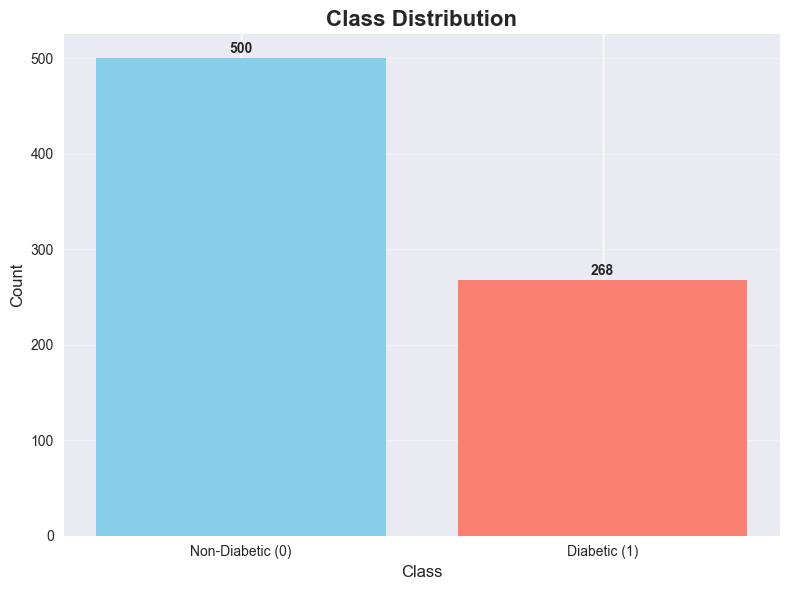

In [5]:
# Class distribution
# Import matplotlib if not already imported
if 'plt' not in globals():
    import matplotlib.pyplot as plt

print("=" * 60)
print("CLASS DISTRIBUTION")
print("=" * 60)
class_counts = df['Outcome'].value_counts()
print(f"\nClass Distribution:")
print(class_counts)
print(f"\nPercentage:")
print(df['Outcome'].value_counts(normalize=True) * 100)

# Visualize class distribution
plt.figure(figsize=(8, 6))
plt.bar(['Non-Diabetic (0)', 'Diabetic (1)'], class_counts.values, color=['skyblue', 'salmon'])
plt.title('Class Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 5, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('../models/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


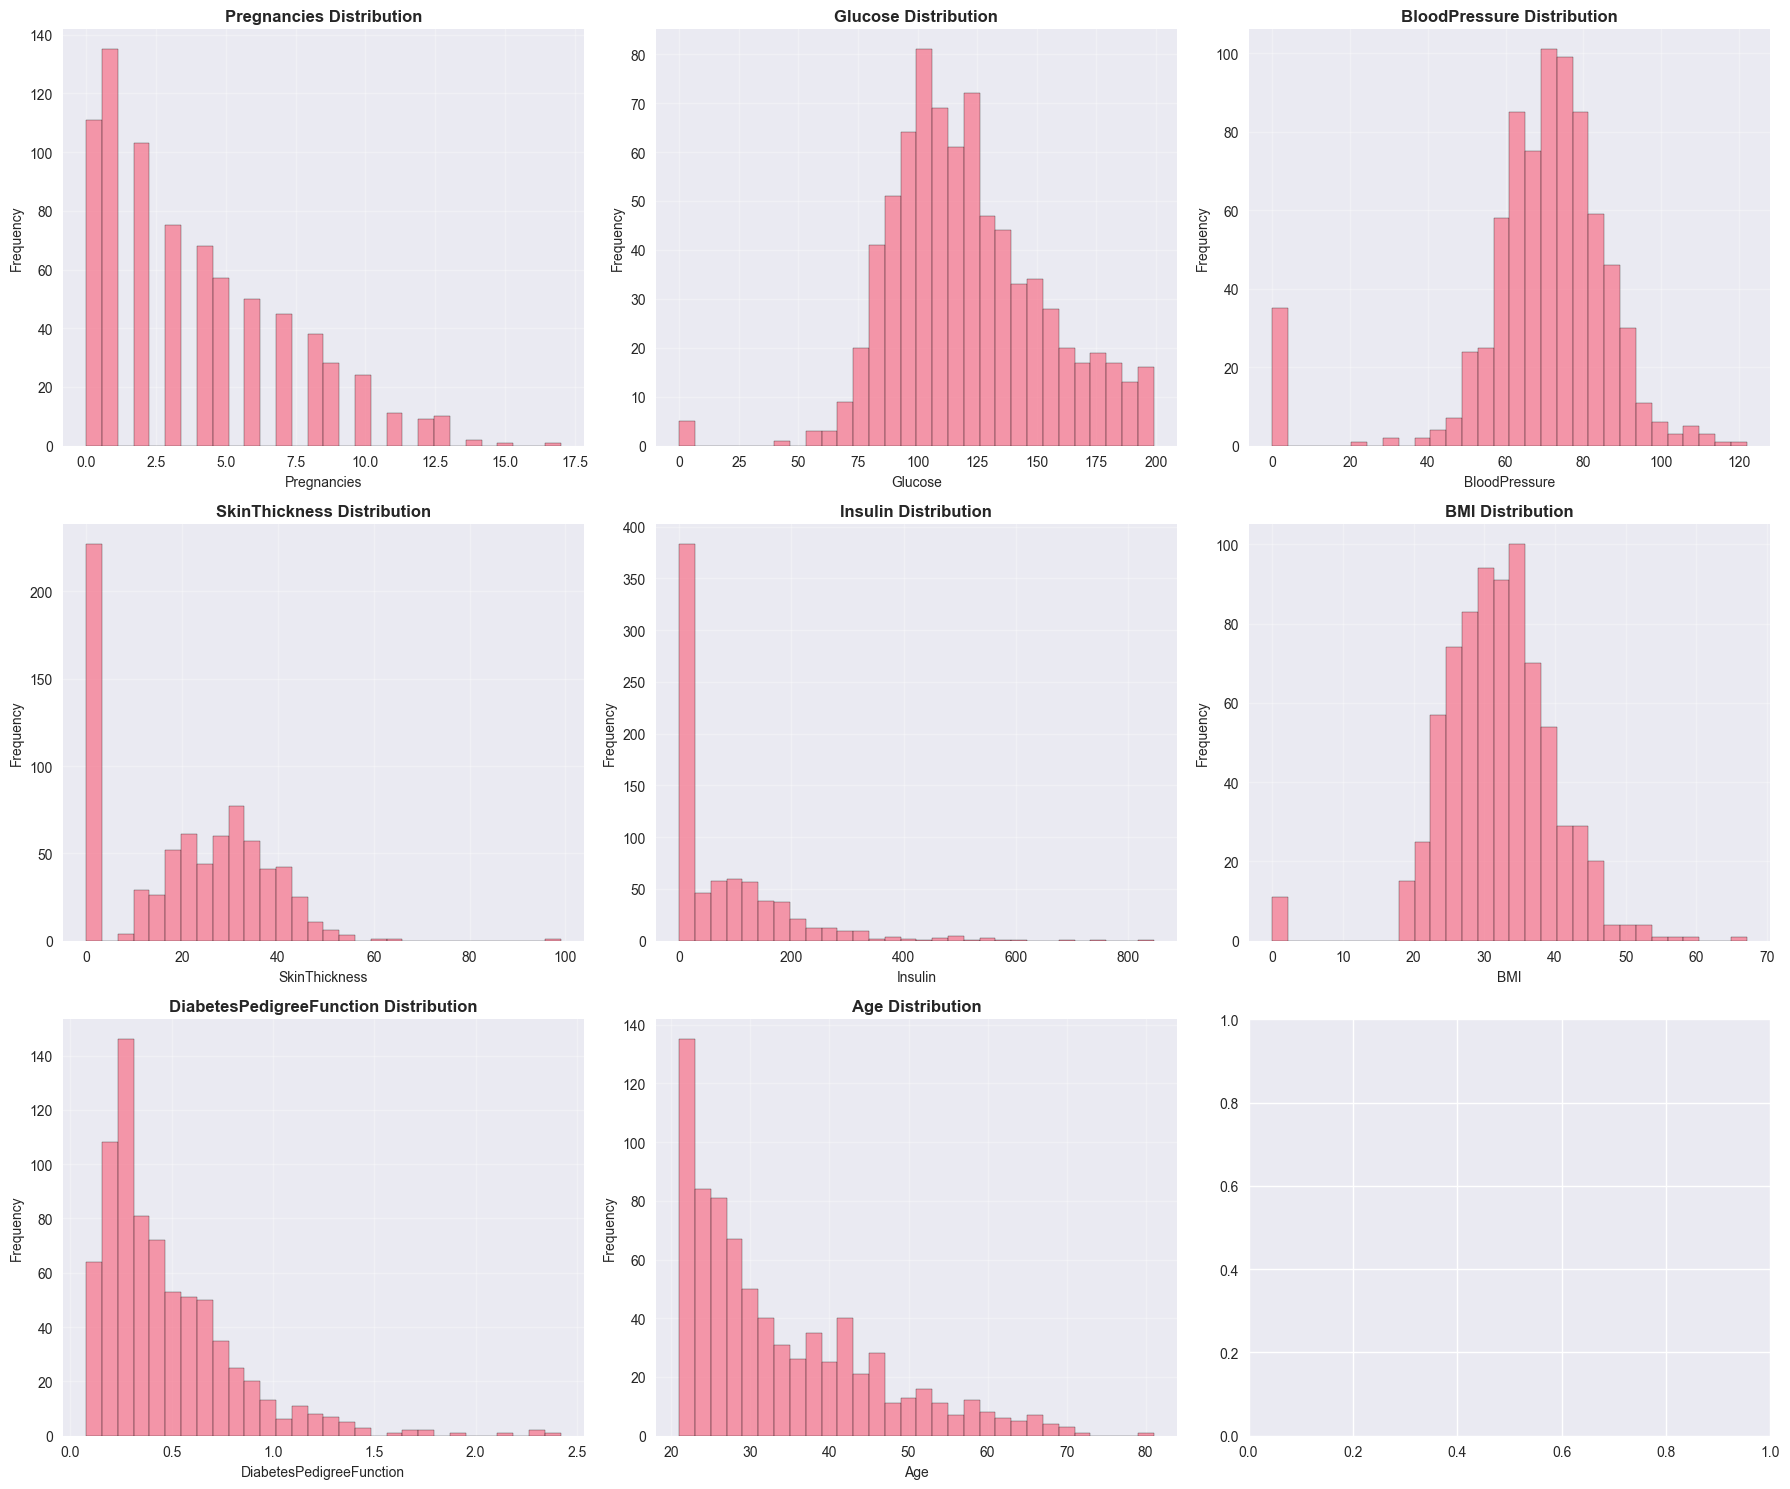

In [6]:
# Feature distributions
# Import matplotlib if not already imported
if 'plt' not in globals():
    import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

features = [col for col in df.columns if col != 'Outcome']

for idx, feature in enumerate(features):
    df[feature].hist(ax=axes[idx], bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{feature} Distribution', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(feature, fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../models/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


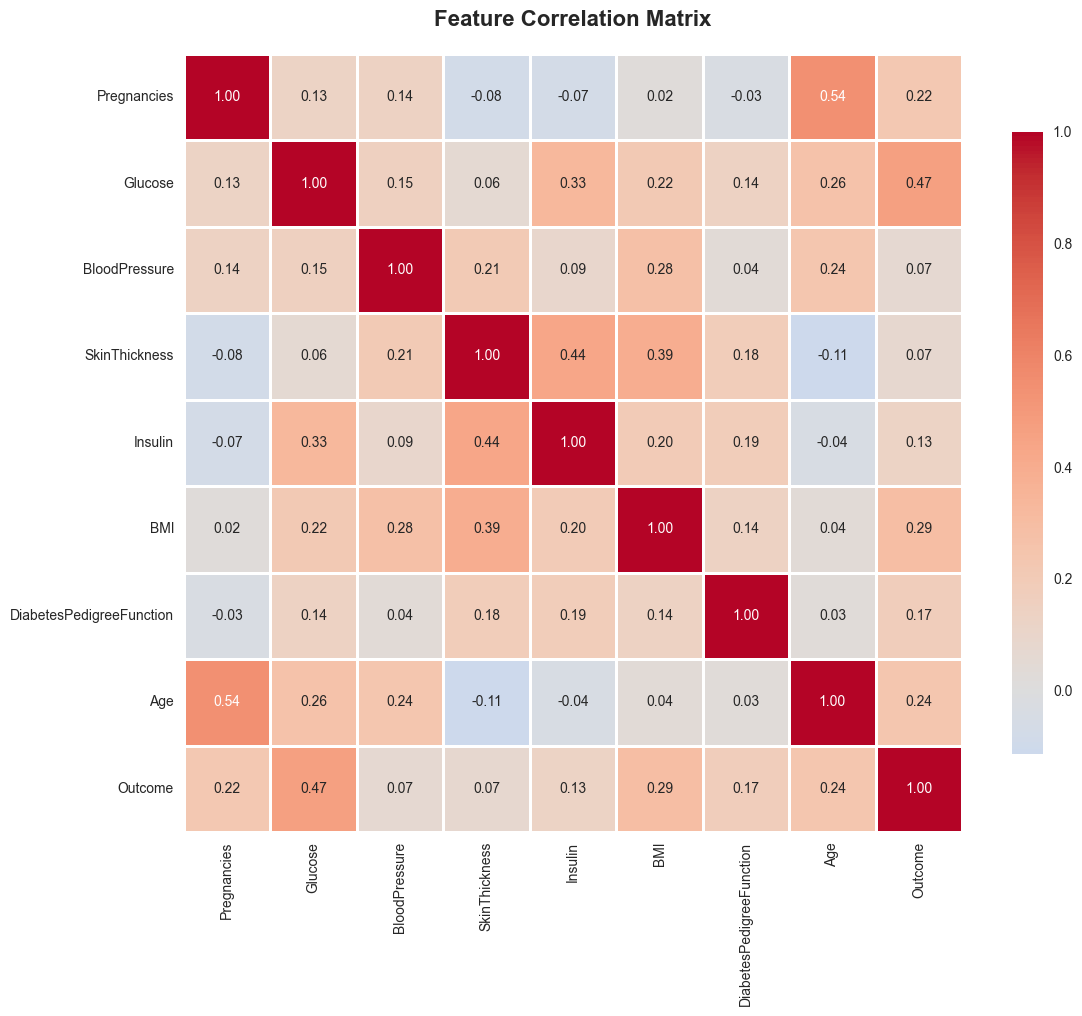


Correlation with Outcome:
Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


In [7]:
# Correlation matrix
# Import matplotlib and seaborn if not already imported
if 'plt' not in globals():
    import matplotlib.pyplot as plt
if 'sns' not in globals():
    import seaborn as sns

plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../models/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Show correlation with Outcome
print("\nCorrelation with Outcome:")
print(correlation_matrix['Outcome'].sort_values(ascending=False))


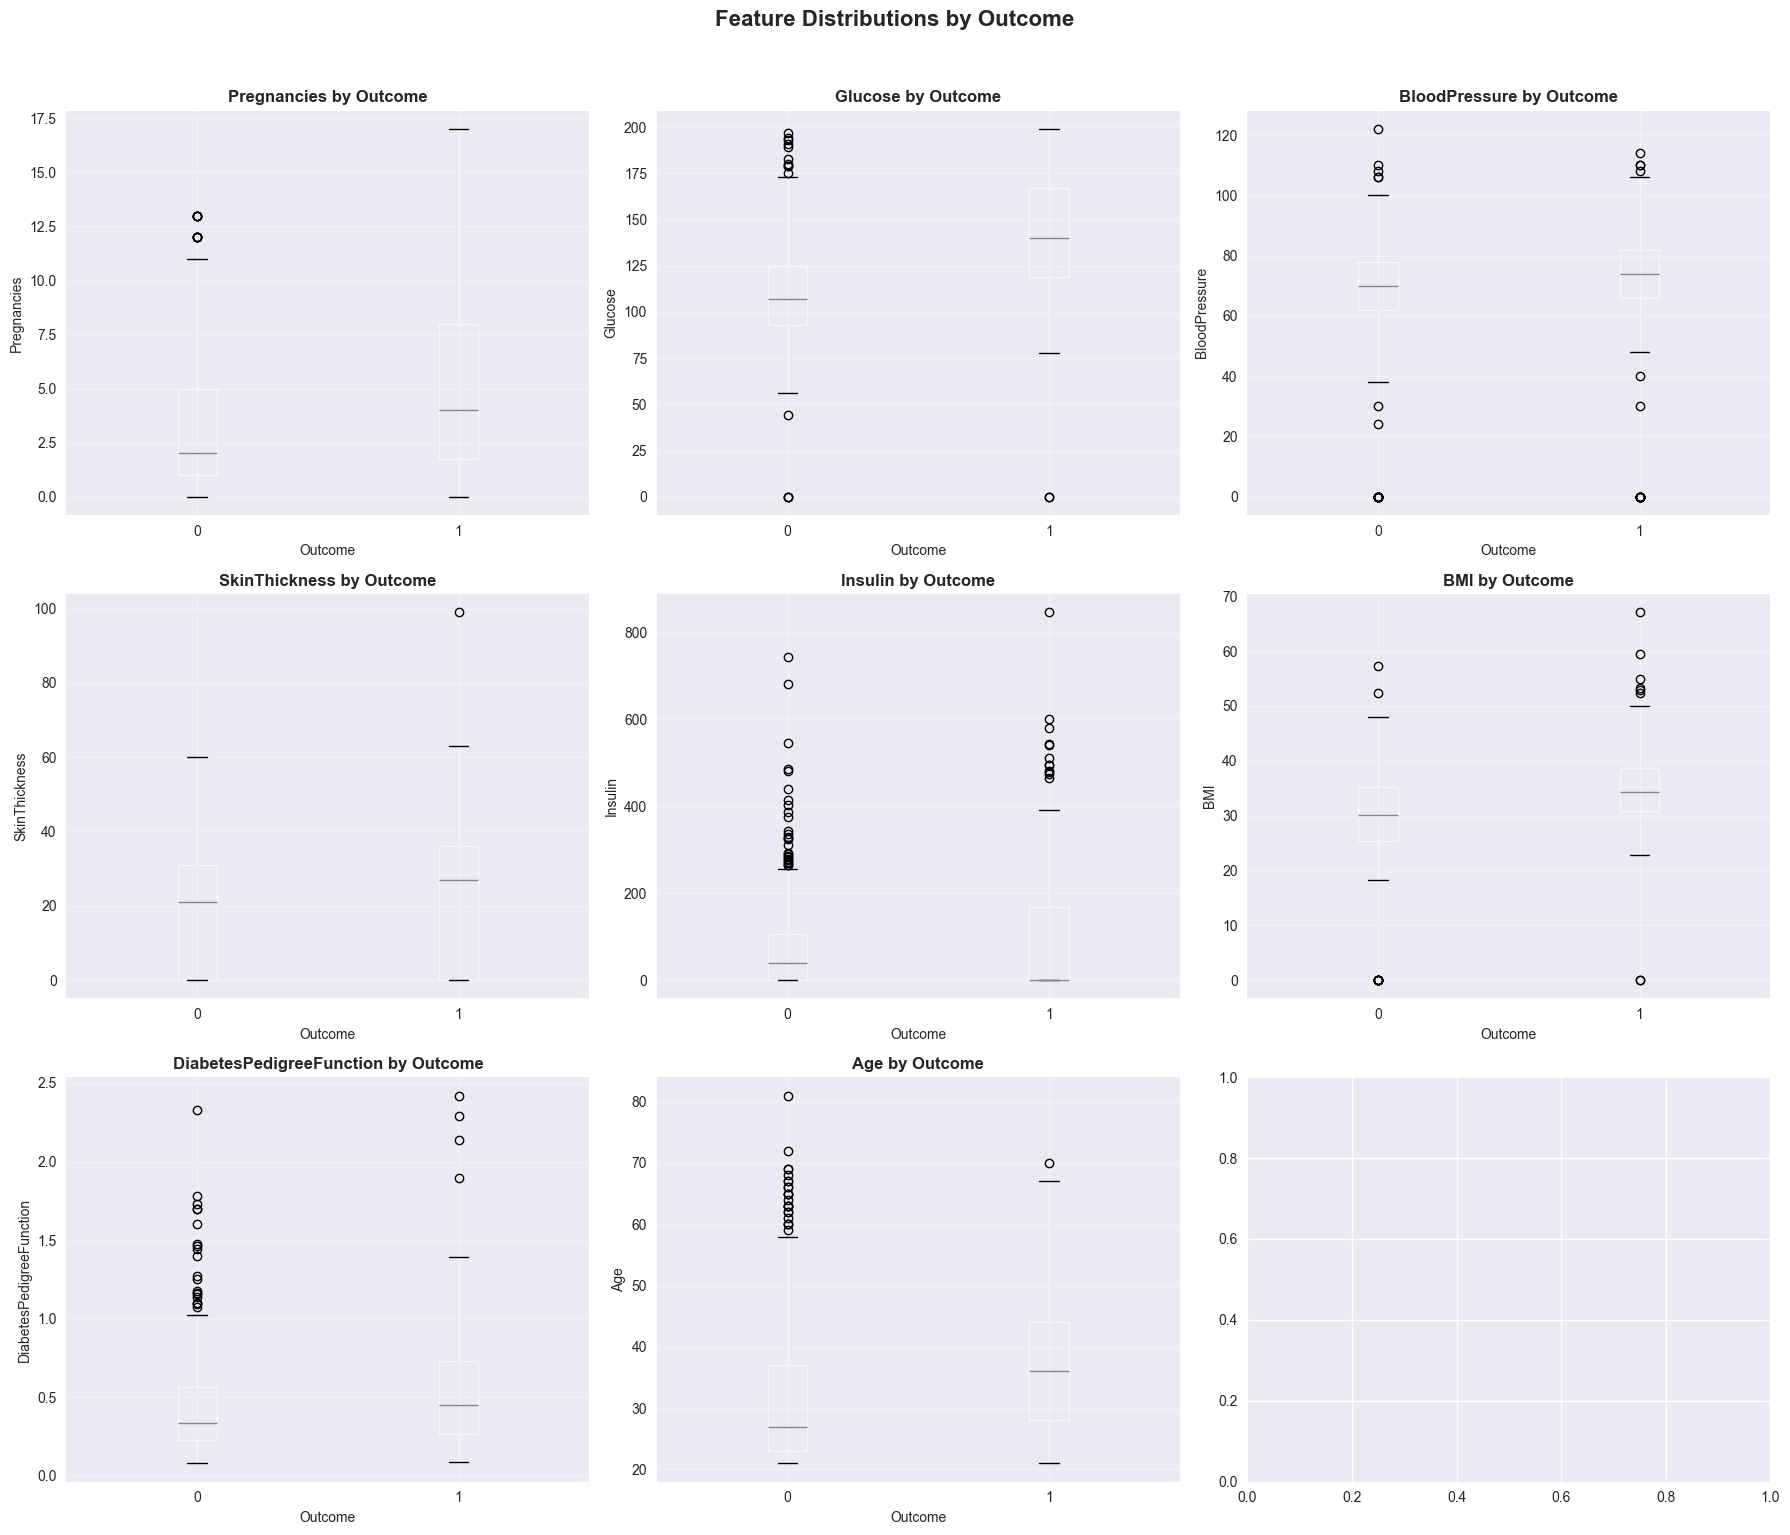

In [8]:
# Box plots for features by outcome
# Import matplotlib if not already imported
if 'plt' not in globals():
    import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

features = [col for col in df.columns if col != 'Outcome']

for idx, feature in enumerate(features):
    df.boxplot(column=feature, by='Outcome', ax=axes[idx])
    axes[idx].set_title(f'{feature} by Outcome', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Outcome', fontsize=10)
    axes[idx].set_ylabel(feature, fontsize=10)
    axes[idx].grid(alpha=0.3)

plt.suptitle('Feature Distributions by Outcome', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../models/boxplots_by_outcome.png', dpi=300, bbox_inches='tight')
plt.show()


## Step 3: Data Preprocessing


In [9]:
# Create a copy for preprocessing
df_processed = df.copy()

# Replace zero values in key features with NaN
# These features cannot realistically be zero
features_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

print("=" * 60)
print("DATA PREPROCESSING")
print("=" * 60)

for feature in features_to_check:
    if feature in df_processed.columns:
        zero_count = (df_processed[feature] == 0).sum()
        df_processed[feature] = df_processed[feature].replace(0, np.nan)
        print(f"Replaced {zero_count} zeros in {feature} with NaN")

# Separate features and target
X = df_processed.drop('Outcome', axis=1)
y = df_processed['Outcome']

print(f"\nMissing values after zero replacement:")
print(X.isnull().sum())


DATA PREPROCESSING
Replaced 5 zeros in Glucose with NaN
Replaced 35 zeros in BloodPressure with NaN
Replaced 227 zeros in SkinThickness with NaN
Replaced 374 zeros in Insulin with NaN
Replaced 11 zeros in BMI with NaN

Missing values after zero replacement:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64


In [10]:
# Impute missing values with median
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print("Missing values after imputation:")
print(X_imputed.isnull().sum().sum())

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)

print(f"\nFinal preprocessed data shape: {X_scaled.shape}")
print(f"\nFirst few rows of scaled data:")
X_scaled.head()


Missing values after imputation:
0

Final preprocessed data shape: (768, 8)

First few rows of scaled data:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.866045,-0.031990,0.670643,-0.181541,0.166619,0.468492,1.425995
1,-0.844885,-1.205066,-0.528319,-0.012301,-0.181541,-0.852200,-0.365061,-0.190672
2,1.233880,2.016662,-0.693761,-0.012301,-0.181541,-1.332500,0.604397,-0.105584
3,-0.844885,-1.073567,-0.528319,-0.695245,-0.540642,-0.633881,-0.920763,-1.041549
4,-1.141852,0.504422,-2.679076,0.670643,0.316566,1.549303,5.484909,-0.020496


In [11]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("=" * 60)
print("DATA SPLIT")
print("=" * 60)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"\nClass distribution in testing set:")
print(y_test.value_counts())


DATA SPLIT
Training set: 614 samples
Testing set: 154 samples

Class distribution in training set:
Outcome
0    400
1    214
Name: count, dtype: int64

Class distribution in testing set:
Outcome
0    100
1     54
Name: count, dtype: int64


## Step 4: Model Training

We'll train 4 different models:
1. Logistic Regression
2. Random Forest
3. XGBoost
4. TensorFlow Neural Network


In [12]:
# Create models directory
os.makedirs('../models', exist_ok=True)

# Save preprocessors
joblib.dump(scaler, '../models/scaler.pkl')
joblib.dump(imputer, '../models/imputer.pkl')
print("Preprocessors saved successfully!")


Preprocessors saved successfully!


### 4.1 Logistic Regression


In [13]:
print("=" * 60)
print("TRAINING LOGISTIC REGRESSION")
print("=" * 60)

# Hyperparameter tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_lr = grid_search.best_estimator_
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Save model
joblib.dump(best_lr, '../models/logistic_regression.pkl')
print("\nLogistic Regression model saved!")


TRAINING LOGISTIC REGRESSION
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score: 0.8435

Logistic Regression model saved!


### 4.2 Random Forest


In [14]:
print("=" * 60)
print("TRAINING RANDOM FOREST")
print("=" * 60)

# Hyperparameter tuning (reduced grid for faster training)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Save model
joblib.dump(best_rf, '../models/random_forest.pkl')
print("\nRandom Forest model saved!")


TRAINING RANDOM FOREST
Fitting 5 folds for each of 24 candidates, totalling 120 fits



Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best CV score: 0.8324

Random Forest model saved!


### 4.3 XGBoost


In [15]:
if XGBOOST_AVAILABLE:
    print("=" * 60)
    print("TRAINING XGBOOST")
    print("=" * 60)
    
    # Hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 0.9]
    }
    
    xgb_model = xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss')
    grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_xgb = grid_search.best_estimator_
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    # Save model
    joblib.dump(best_xgb, '../models/xgboost.pkl')
    print("\nXGBoost model saved!")
else:
    print("=" * 60)
    print("SKIPPING XGBOOST TRAINING")
    print("=" * 60)
    print("XGBoost is not available. Skipping XGBoost model training.")
    print("To enable XGBoost, install libomp: brew install libomp")
    best_xgb = None


TRAINING XGBOOST
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best CV score: 0.8313

XGBoost model saved!


### 4.4 TensorFlow Neural Network


TRAINING TENSORFLOW NEURAL NETWORK

Training Neural Network...
Epoch 1/100
20/20 [==============================] - 3s 28ms/step - loss: 0.6476 - accuracy: 0.6547 - val_loss: 0.5949 - val_accuracy: 0.7403
Epoch 2/100
20/20 [==============================] - 0s 8ms/step - loss: 0.5794 - accuracy: 0.6906 - val_loss: 0.5379 - val_accuracy: 0.7338
Epoch 3/100
20/20 [==============================] - 0s 6ms/step - loss: 0.5359 - accuracy: 0.7443 - val_loss: 0.5135 - val_accuracy: 0.7143
Epoch 4/100
20/20 [==============================] - 0s 6ms/step - loss: 0.4998 - accuracy: 0.7524 - val_loss: 0.5101 - val_accuracy: 0.7338
Epoch 5/100
20/20 [==============================] - 0s 8ms/step - loss: 0.5112 - accuracy: 0.7362 - val_loss: 0.5131 - val_accuracy: 0.7273
Epoch 6/100
20/20 [==============================] - 0s 8ms/step - loss: 0.4988 - accuracy: 0.7508 - val_loss: 0.5166 - val_accuracy: 0.7273
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4743 - accuracy

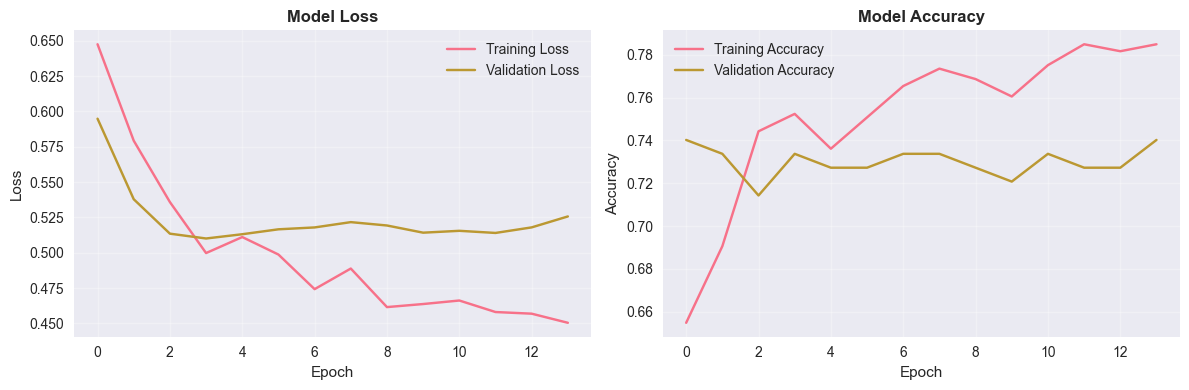

In [16]:
print("=" * 60)
print("TRAINING TENSORFLOW NEURAL NETWORK")
print("=" * 60)

# Convert to numpy arrays
X_train_np = X_train.values
X_test_np = X_test.values

# Build model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_np.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train model
print("\nTraining Neural Network...")
history = model.fit(
    X_train_np, y_train,
    validation_data=(X_test_np, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Save model
model.save('../models/neural_network.h5')
print("\nNeural Network model saved!")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../models/nn_training_history.png', dpi=300, bbox_inches='tight')
plt.show()


In [17]:
# Load all models for evaluation
models = {
    'Logistic Regression': best_lr,
    'Random Forest': best_rf,
    'Neural Network': model
}

# Add XGBoost only if available
if XGBOOST_AVAILABLE and best_xgb is not None:
    models['XGBoost'] = best_xgb

# Evaluate all models
results = []

for model_name, model_obj in models.items():
    if model_name == 'Neural Network':
        # TensorFlow model
        y_pred_proba = model_obj.predict(X_test_np, verbose=0).ravel()
        y_pred = (y_pred_proba >= 0.5).astype(int)
    else:
        # Sklearn models
        y_pred = model_obj.predict(X_test)
        y_pred_proba = model_obj.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    })
    
    print(f"\n{model_name} Results:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': [r['Model'] for r in results],
    'Accuracy': [r['Accuracy'] for r in results],
    'Precision': [r['Precision'] for r in results],
    'Recall': [r['Recall'] for r in results],
    'F1-Score': [r['F1-Score'] for r in results],
    'ROC-AUC': [r['ROC-AUC'] for r in results]
})

comparison_df = comparison_df.round(4)
comparison_df = comparison_df.sort_values('ROC-AUC', ascending=False)

print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(comparison_df.to_string(index=False))



Logistic Regression Results:
  Accuracy:  0.6948
  Precision: 0.5745
  Recall:    0.5000
  F1-Score:  0.5347
  ROC-AUC:   0.8128

Random Forest Results:
  Accuracy:  0.7468
  Precision: 0.6531
  Recall:    0.5926
  F1-Score:  0.6214
  ROC-AUC:   0.8091

Neural Network Results:
  Accuracy:  0.7338
  Precision: 0.6226
  Recall:    0.6111
  F1-Score:  0.6168
  ROC-AUC:   0.8013

XGBoost Results:
  Accuracy:  0.7208
  Precision: 0.6279
  Recall:    0.5000
  F1-Score:  0.5567
  ROC-AUC:   0.8141

MODEL COMPARISON
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
            XGBoost    0.7208     0.6279  0.5000    0.5567   0.8141
Logistic Regression    0.6948     0.5745  0.5000    0.5347   0.8128
      Random Forest    0.7468     0.6531  0.5926    0.6214   0.8091
     Neural Network    0.7338     0.6226  0.6111    0.6168   0.8013


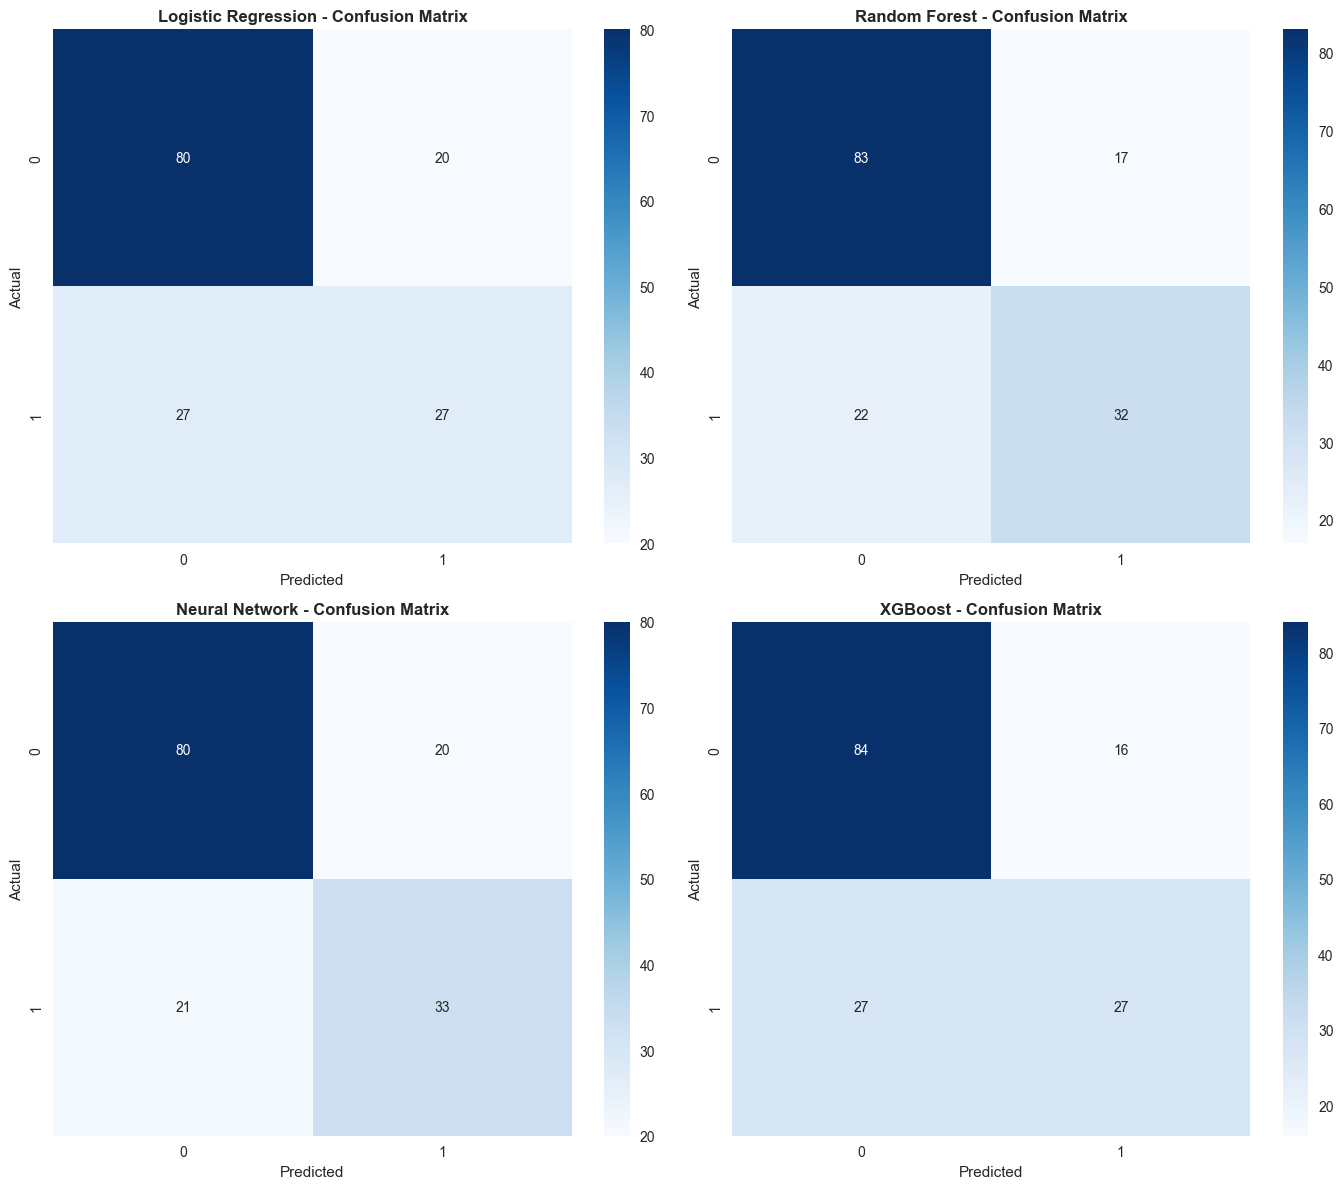

In [18]:
# Confusion matrices
# Import matplotlib and seaborn if not already imported
if 'plt' not in globals():
    import matplotlib.pyplot as plt
if 'sns' not in globals():
    import seaborn as sns

n_models = len(results)
n_cols = 2
n_rows = (n_models + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6*n_rows))
if n_models == 1:
    axes = [axes]
else:
    axes = axes.ravel()

for idx, result in enumerate(results):
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{result["Model"]} - Confusion Matrix', fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

# Hide unused subplots
for idx in range(n_models, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('../models/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()


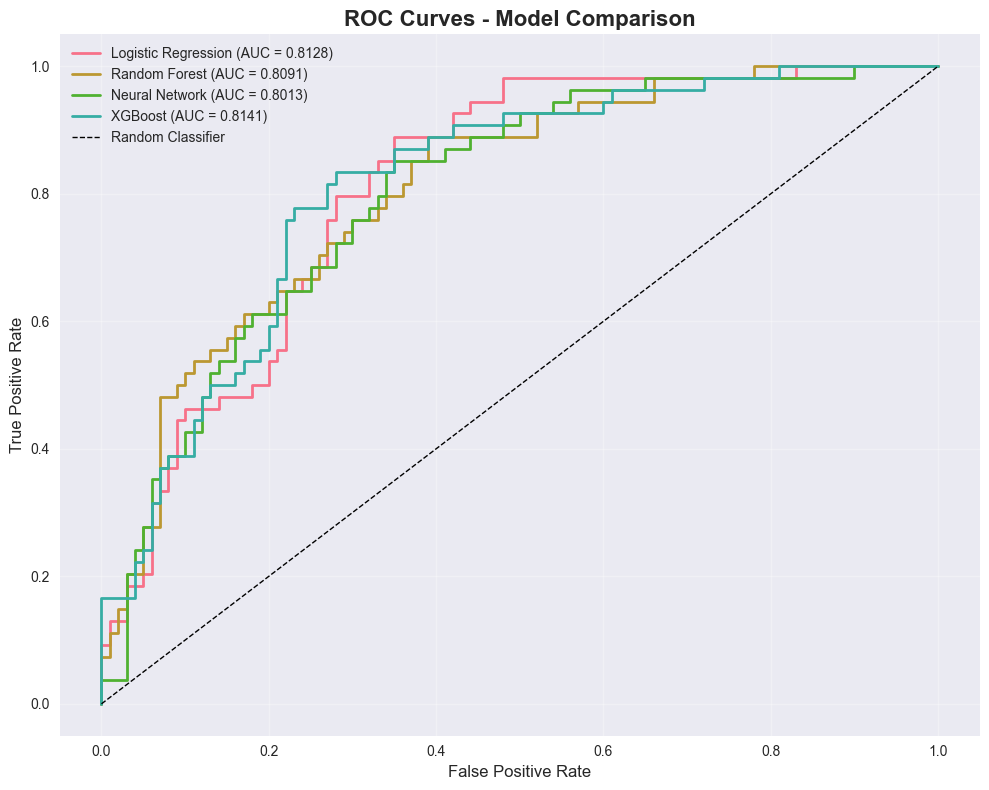

In [19]:
# ROC curves
# Import matplotlib if not already imported
if 'plt' not in globals():
    import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

for result in results:
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{result['Model']} (AUC = {result['ROC-AUC']:.4f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=16, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../models/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()


In [20]:
# Save comparison results
comparison_df.to_csv('../models/model_comparison.csv', index=False)

# Determine and save best model
best_model_name = comparison_df.iloc[0]['Model']
with open('../models/best_model.txt', 'w') as f:
    f.write(best_model_name)

print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model_name}")
print(f"ROC-AUC Score: {comparison_df.iloc[0]['ROC-AUC']:.4f}")
print(f"{'='*60}")

print("\nAll models and results saved to ../models/ directory!")



BEST MODEL: XGBoost
ROC-AUC Score: 0.8141

All models and results saved to ../models/ directory!


## Summary

This notebook has completed:
1. ✅ Data loading and exploration
2. ✅ Comprehensive EDA with visualizations
3. ✅ Data preprocessing (handling missing values, scaling)
4. ✅ Training 4 different ML models
5. ✅ Model evaluation and comparison
6. ✅ Saving all models and preprocessors for Flask application

### Saved Files:
- `../models/scaler.pkl` - Feature scaler
- `../models/imputer.pkl` - Missing value imputer
- `../models/logistic_regression.pkl` - Logistic Regression model
- `../models/random_forest.pkl` - Random Forest model
- `../models/xgboost.pkl` - XGBoost model
- `../models/neural_network.h5` - Neural Network model
- `../models/best_model.txt` - Best model name
- `../models/model_comparison.csv` - Model comparison results
- Various visualization PNG files

### Next Steps:
1. The Flask application (`app.py`) can now use these saved models
2. Run the Flask app: `python app.py`
3. Access the web interface at http://localhost:5000
